In [5]:

from twmyle.pyutils import env_arg , set_gpu
EXP_NAME = env_arg( "EXP_NAME" , default="nqae_50" )  
do_quantize = env_arg( "do_quantize" , default=True , type=True  )   
net_arch = env_arg("net_arch" , default="50")
gpu = env_arg("gpu" , default=2 )


set_gpu( gpu )


EXP_NAME -> nqae_50 (default)
do_quantize -> True (default)
net_arch -> 50 (default)


In [3]:
! nvidia-smi

Mon May  4 01:45:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.74       Driver Version: 418.74       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 46%   76C    P2   127W / 250W |   3638MiB / 12196MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   42C    P5    22W / 250W |    924MiB / 12196MiB |     14%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
from keras.layers import *
from keras.models import *

Using TensorFlow backend.
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sc

In [4]:
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework import ops


In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import keras 
keras.__version__

'2.3.1'

In [7]:
eps = 0.0000001

In [8]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

def discrete_func(x , np_fn , name=None):
    
    with ops.name_scope(name, "Mysquare", [x]) as name:
        sqr_x = py_func( np_fn ,
                        [x],
                        [tf.float32],
                        name=name,
                        grad=_identity_grad)  
        sqr_x[0].set_shape(x.shape)
        return sqr_x[0]

# Actual gradient:
def _identity_grad(op, grad):
    return grad 


def binarize_np( x ):
    a = np.zeros_like( x  )
    a[x>0.5] = 1
    return a

def onehot_np( x ):
    assert len(x.shape) == 2
    inds = x.argmax(-1)
    a = np.zeros_like( x  )
    a[ range( len(inds) ) ,inds] = 1
    return a 

def Dis_Binarize():
    return Lambda( lambda x: discrete_func(x , binarize_np )  )


def Dis_OneHot():
    return Lambda( lambda x: discrete_func(x , onehot_np )  )


In [25]:
layer_sizes = net_arch.split("_")
layer_sizes = map(int , layer_sizes )

In [27]:
inp_img = Input((28,28,1))

x =  Reshape((28*28*1,))(inp_img)

for ll in layer_sizes:
    x = Dense( ll )(x )
    x = Activation('relu')(x)


before_dis = x
x = Activation('sigmoid')(x)
enc_out = x 
    

# decocder
inp_hidden = Input((layer_sizes[-1],))

x = inp_hidden

for ll in layer_sizes[:-1][::-1]:
    x = Dense( ll )(x )
    x = Activation('relu')(x)

x = Dense( 28*28 )(x)


x = Activation('sigmoid')(x)
y = Reshape((28,28,1))(x)
m_dec = Model( inp_hidden , y )

m_enc = Model( inp_img , enc_out )

m = Model(input=inp_img, output=m_dec(enc_out)  )


m.compile(loss='binary_crossentropy', optimizer='adam' )
    

/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [28]:
m.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 1)         39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_______________________________________________________

In [29]:
m_enc.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
Total params: 39,250
Trainable params: 39,250
Non-trainable params: 0
_________________________________________________________________


In [30]:
m_dec.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               39984     
_________________________________________________________________
activation_8 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
Total params: 39,984
Trainable params: 39,984
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def quantize(x):
    return ( x > 0.5 ).astype(float)

In [31]:
def show_recon( ):
    x = x_train[:10]
    xp = m.predict(x ) ; 
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
        
    plt.imshow(a)
    plt.show()
    plt.imshow(b)
    plt.show()

In [32]:
def show_recon( ):
    x = x_train[:10]
    codes = m_enc.predict(x ) 
    codes = quantize(codes )
    xp = m_dec.predict( codes )
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
        
    plt.imshow(a)
    plt.show()
    plt.imshow(b)
    plt.show()

In [33]:
def save_stuff( ):
    x = x_train 
    codes = (m_enc.predict(x ) )
    if do_quantize:
        codes = quantize(codes)
    xp = m_dec.predict( codes )
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
    
    np.savez( "outs/"+EXP_NAME + ".npz" , 
		original=(x*255).astype('uint8') , 
		encoded=codes.astype('uint8') , 
        decoded=(xp*255).astype('uint8')    )
    


In [34]:
from keras.datasets import mnist

In [35]:
img_rows, img_cols = 28, 28
num_classes = 10
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [36]:
# m.predict(x_train[:10])

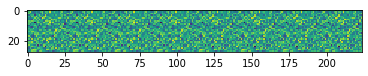

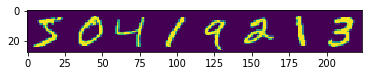

In [37]:
show_recon()

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 26s 427us/step - loss: 0.2512 - val_loss: 0.2192


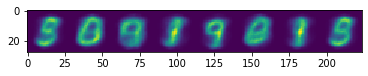

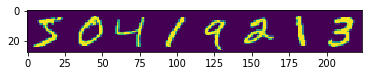

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 26s 433us/step - loss: 0.1986 - val_loss: 0.1823


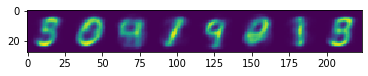

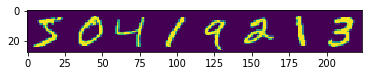

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
11488/60000 [====>.........................] - ETA: 19s - loss: 0.1818

In [ ]:
for ep in range(10):
    m.fit(x_train, x_train,
              batch_size=16,
              epochs=1,
              verbose=1,
              validation_data=(x_test, x_test))
    show_recon( )

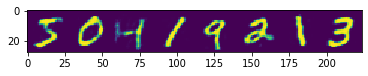

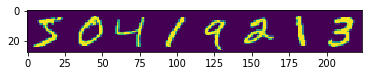

In [23]:
show_recon()

In [ ]:
save_stuff()